In [1]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

from ta.trend import ema_indicator

from modules.Utils.utils import loadFromDB, strategyTester



In [2]:
def emd(signal):
    emd = EMD(DTYPE=np.float16, spline_kind='cubic')
    imfs = emd(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[0]
    fig, axs = plt.subplots(N + 1, 1, figsize=(25,11))
    axs[0].plot(t, signal)
    axs[0].set_title('Original Signal')
    for n, imf in enumerate(imfs):
        axs[n+1].plot(t, imf)
        axs[n+1].set_title(f'IMF {n}')
    
    return imfs

In [23]:

SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv').iloc[-10000:]
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(9981, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA20
Date,,,,,,,
2021-05-07 16:00:00,56989.9,57193.0,56656.7,57121.8,399.020628,1620396000,56403.724715
2021-05-07 17:00:00,57121.7,57591.0,57051.5,57520.1,277.979430,1620399600,56510.046171
2021-05-07 18:00:00,57518.3,58300.0,57152.8,58292.1,477.666151,1620403200,56679.765583
2021-05-07 19:00:00,58292.1,58643.2,57969.6,58123.2,395.615209,1620406800,56817.235528
2021-05-07 20:00:00,58123.3,58130.8,57630.5,57895.1,282.845797,1620410400,56919.889287


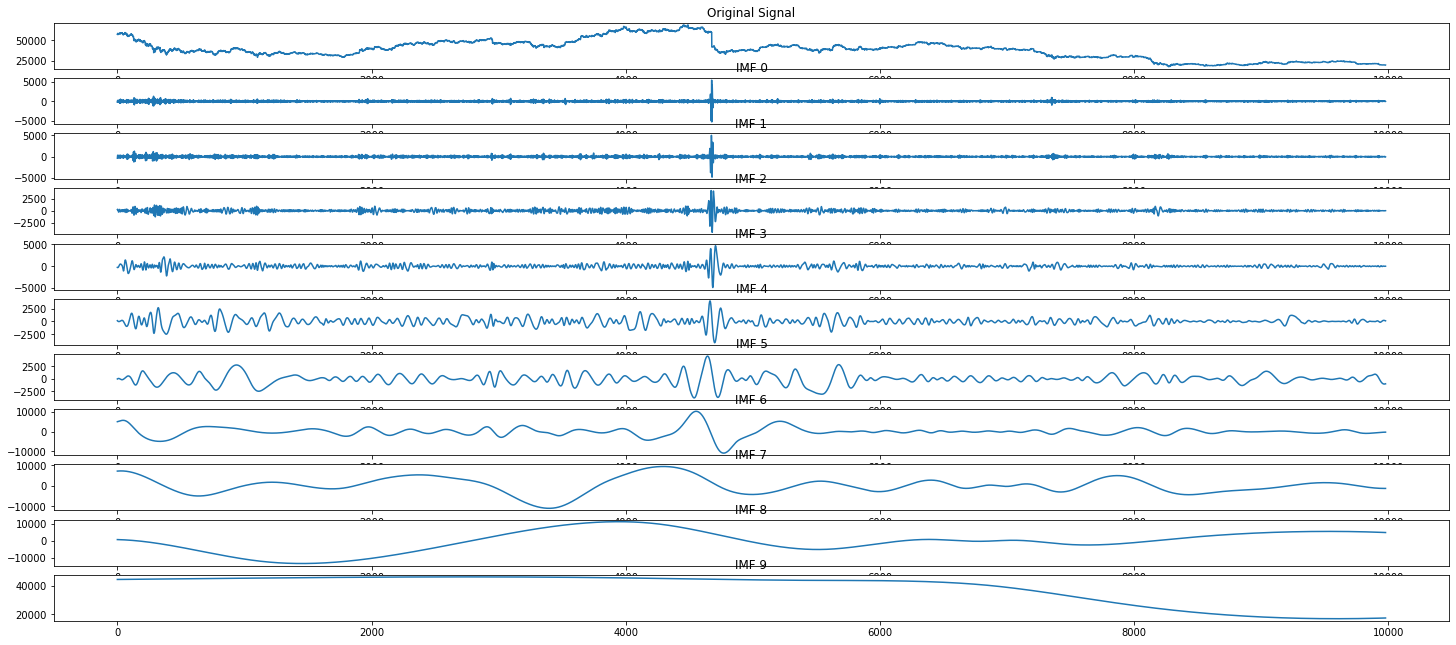

In [24]:
imfs = emd(df["Close"])

In [25]:
def phase_spectrum(imfs):
    imfs_p = []
    fig, axs = plt.subplots(len(imfs), 1, figsize=(25,11))
    for i, imf in enumerate(imfs):
        trans = fft(imf)
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

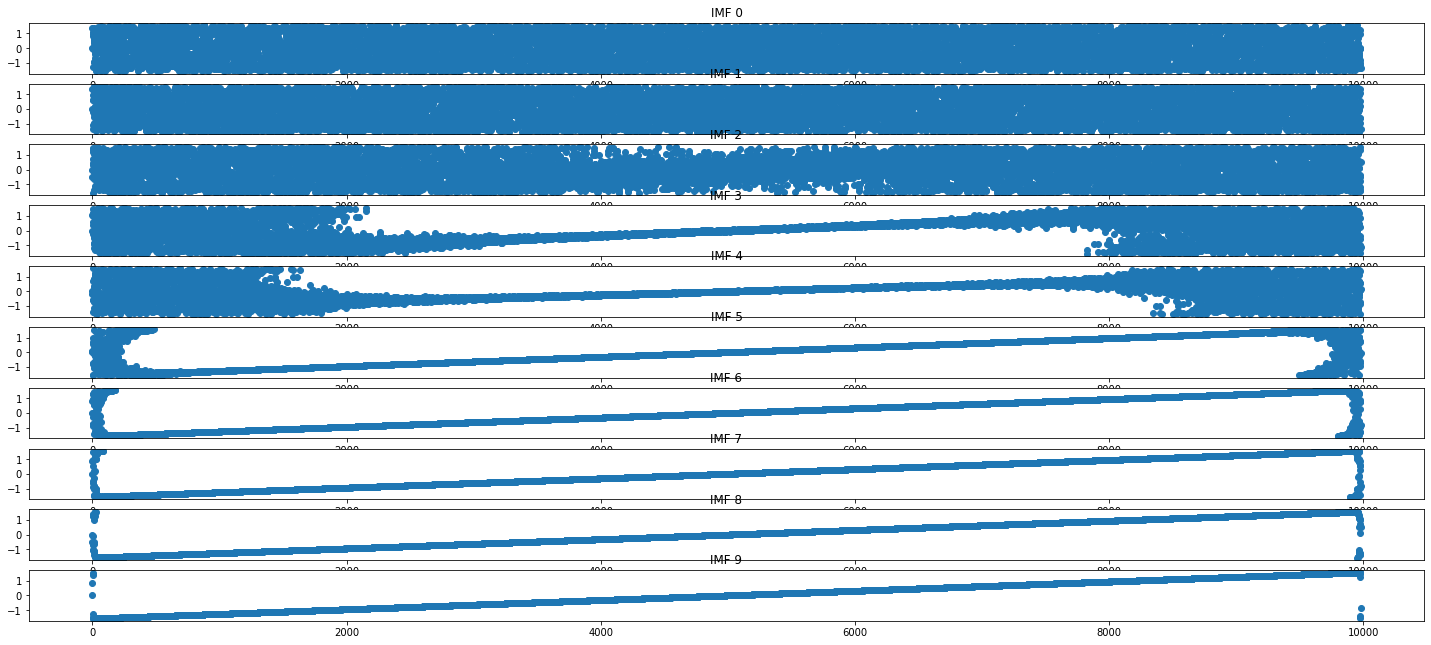

In [26]:
imfs_p = phase_spectrum(imfs)

In [27]:
def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
        
    return np.array(mis)
mis = phase_mi(imfs_p)

In [28]:
def divide_signal(signal, imfs, mis, cutoff=0.5):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:cut_point], axis=0)
    deterministic_component = np.sum(imfs[cut_point:], axis=0)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(25,11))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

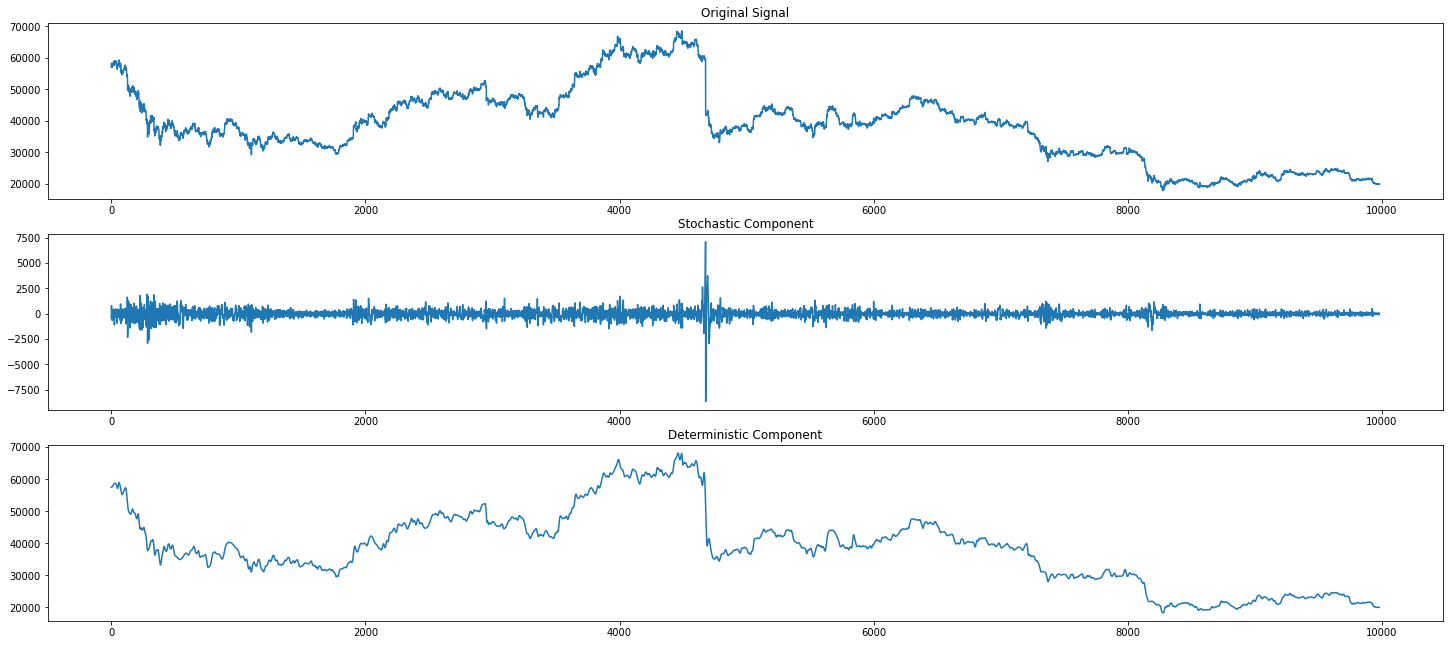

In [29]:
stochastic_component, deterministic_component = divide_signal(df["Close"], imfs, mis,cutoff=0.9)

In [30]:
df['deterministic_component'] = deterministic_component
df['stochastic_component'] = stochastic_component
df['deterministic_component_diff'] = df['deterministic_component'].diff()
df.dropna(inplace=True)

Period : [2021-05-07 17:00:00] -> [2022-08-29 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 994761.54 $
Performance vs US Dollar : 99376.15 %
Buy and Hold Performence : -65.41 %
Performance vs Buy and Hold : -152023.62 %
Best trade : +19.2 %, the 2021-05-25 01:00:00
Worst trade : -7.57 %, the 2022-06-15 09:00:00
Worst drawBack : -9.0 %
Total fees :  74415.35 $

----- Trades Informations -----
Total trades on period : 286
Number of positive trades : 236
Number of negative trades :  50
Trades win rate ratio : 82.52 %
Average trades performance : 2.57 %
Average positive trades : 3.29 %
Average negative trades : -0.83 %

----- Plot -----


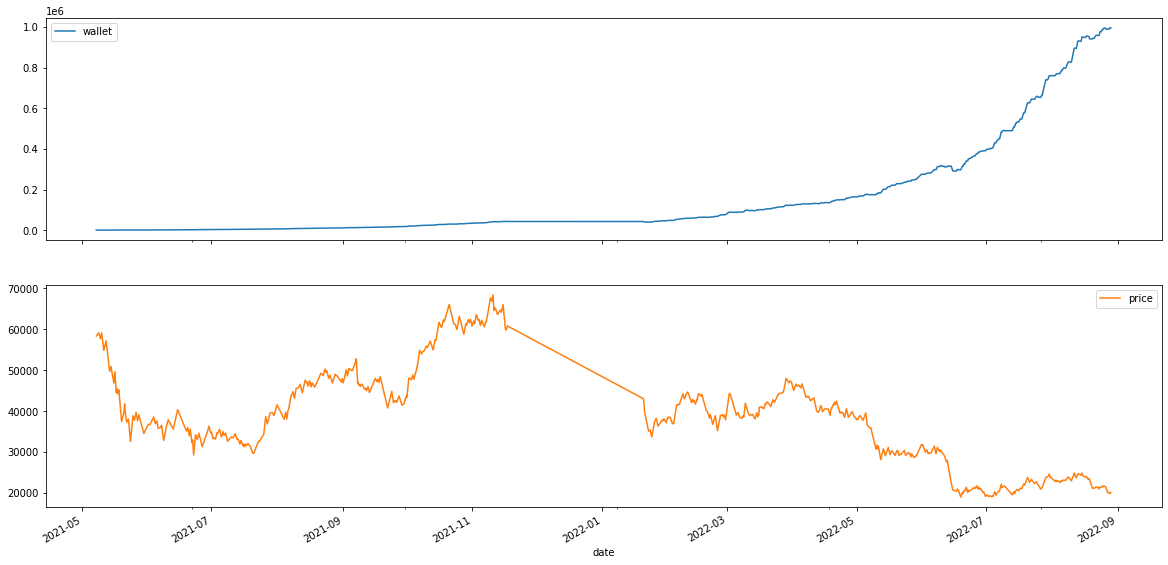

In [31]:
import pandas as pd

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)